In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np
from PIL import Image
import os
import sys
from imutils import paths
from tqdm import tqdm
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

In [3]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


# 1. VERİ TOPLAMA

### 4 farklı veri seti ile çalışacağız. Bunlar aşağıda ki gibidir:

###  1 . Ravdess Veri Seti

#####      Duygu ifade eden konuşma ve şarkıların yüksek kaliteli kayıtlarını içeren bir veri setidir. 
#####      24 farklı oyuncu tarafından İngilizce olarak kaydedilen 1440 ses dosyasını içerir. 
#####      Veri setinde nötr, sakin, mutlu, üzgün, öfkeli, korkmuş, iğrenmiş ve şaşkın olmak üzere sekiz duygu durumu yer alır. 
#####      Bu veri seti, duygu tanıma, konuşma tanıma ve çeşitli ses işleme uygulamaları için kullanılmaktadır.





###  2 . Crema-D Veri Seti

#####       CREMA-D, 91 aktörün 7.442 orijinal klibinden oluşan bir veri setidir. 
#####        Bu klipler, çeşitli ırk ve etnik kökenlerden (Afrika Amerika,  Asya, Kafkas, Hispanik ve Belirtilmemiş)
#####        20 ila 74 yaşları arasındaki 48 erkek ve 43 kadın oyuncuya aittir.
#####        Aktörler 12 cümlelik bir seçkiden konuşmuşlardır. 
#####        Cümleler altı farklı duygu (Öfke, Tiksinti, Korku, Mutluluk, Nötr ve Üzüntü)
#####        Dört farklı duygu seviyesinden (Düşük, Orta, Yüksek ve Belirtilmemiş) biri kullanılarak sunulmuştur.




###  3 . Tess Veri Seti

#####        İki aktris (26 ve 64 yaşlarında) tarafından 'Say the word _' kalıp cümlesi için 200 hedef kelime söylenmiş
#####        Yedi duygunun (öfke, iğrenme, korku, mutluluk, hoş sürpriz, üzüntü ve nötr) her birini içeren kayıtlar yapılmış
#####        Toplamda 2800 adet ses dosyası bulunmaktadır.
#####        Veri kümesi, iki kadın aktörün her biri ve duyguları kendi klasöründe yer alacak şekilde düzenlenmiş
#####        Ses dosyasının formatı bir WAV formatıdır




###  4 . Savee Veri Seti

#####        SAVEE veritabanı, Surrey Üniversitesi'nde lisansüstü öğrencisi ve araştırmacı olan, 
#####        yaşları 27 ila 31 arasında değişen, anadili İngilizce olan dört erkek konuşmacıdan (DC, JE, JK, KL olarak tanımlanmıştır) kaydedilmiştir.
#####        Duygular psikolojik olarak ayrı kategorilerde tanımlanmıştır: öfke, iğrenme, korku, mutluluk, üzüntü ve şaşkınlık. 
#####        7 duygu kategorisinin kaydını sağlamak için nötr duyguyu ekledik. 
#####        Metin materyali duygu başına 15 TIMIT cümlesinden oluşuyordu: 
#####        3 ortak, 2 duyguya özgü ve her duygu için farklı ve fonetik olarak dengelenmiş 10 genel cümle. 
#####        3 ortak ve 2 × 6 = 12 duyguya özgü cümle, 30 nötr cümle verecek şekilde nötr olarak kaydedilmiştir.

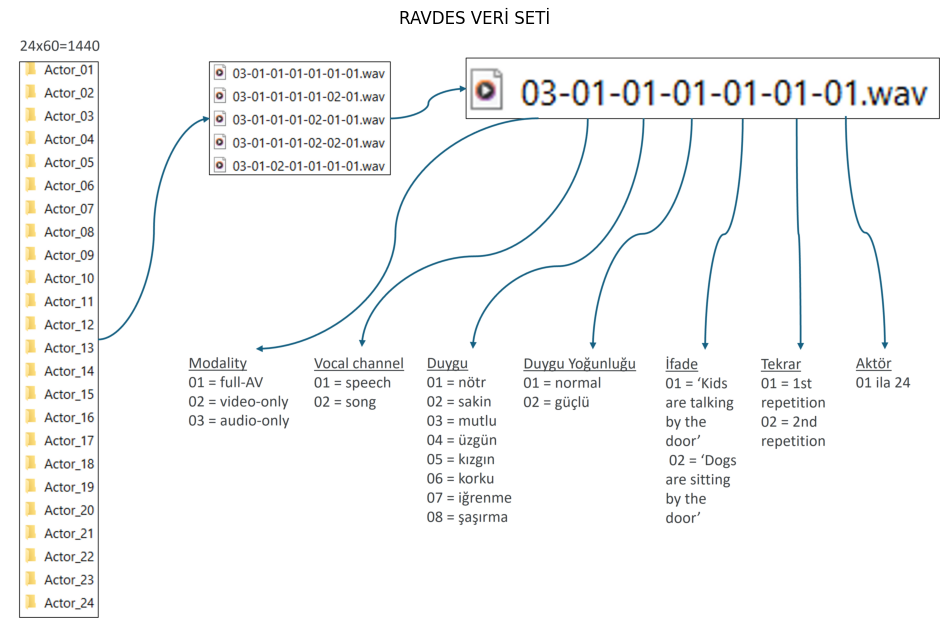

In [4]:
img = Image.open('ravdes.bmp')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)
ax.axis('off')
plt.title('RAVDES VERİ SETİ')
plt.show()

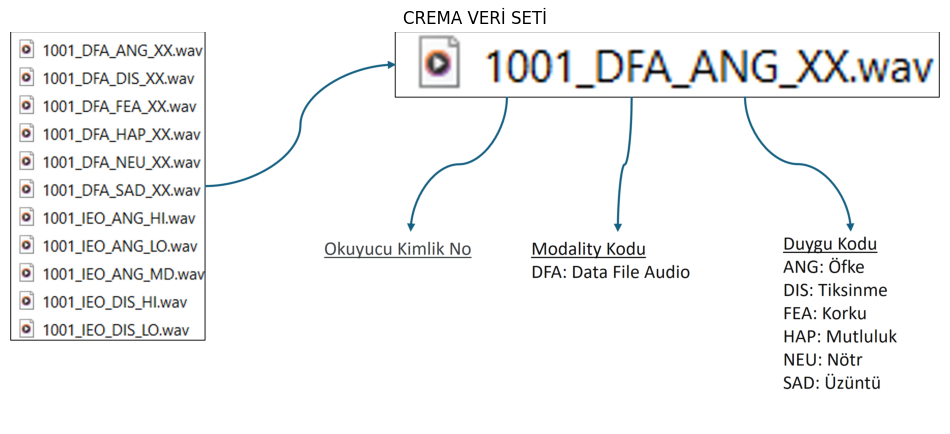

In [5]:
img = Image.open('crema.bmp')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)
ax.axis('off')
plt.title('CREMA VERİ SETİ')
plt.show()

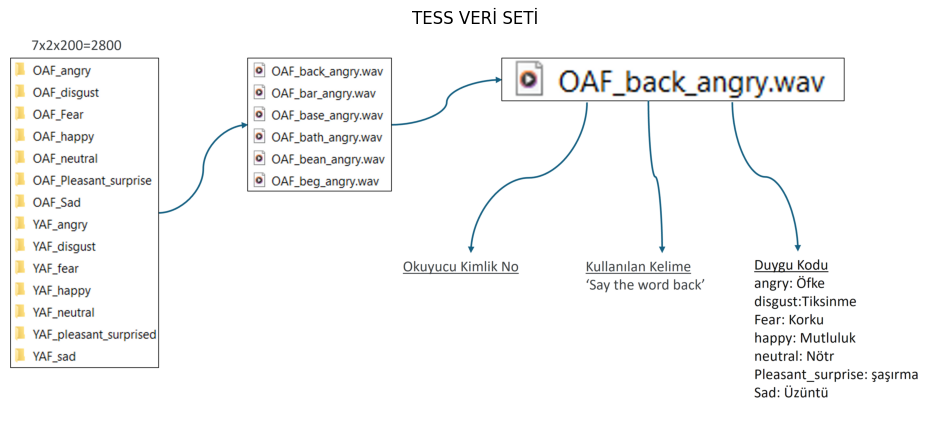

In [6]:
img = Image.open('tess.bmp')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)
ax.axis('off')
plt.title('TESS VERİ SETİ')
plt.show()

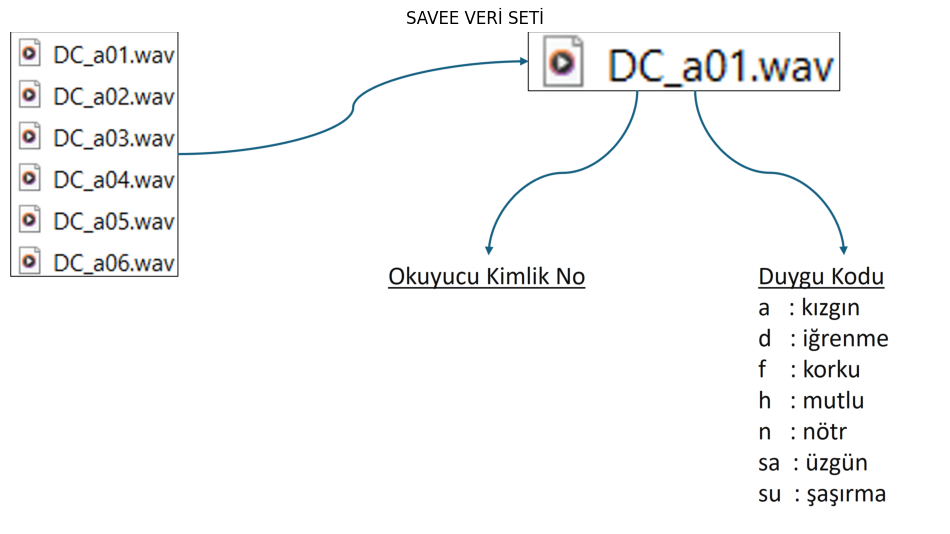

In [116]:
img = Image.open('savee.bmp')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)
ax.axis('off')
plt.title('SAVEE VERİ SETİ')
plt.show()

In [7]:
ravdess_directory_list = os.listdir('Ravdess_veriseti/')

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # Önceki dizinimizde 20 farklı aktör olduğu için her aktör için dosyaları çıkarmamız gerekiyor.
    actor = os.listdir('Ravdess_veriseti/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # Her dosyada üçüncü kısım dosyaya bağlı olan duyguyu temsil eder.
        file_emotion.append(int(part[2]))
        file_path.append('Ravdess_veriseti/' + dir + '/' + file)

In [8]:
# Dosyaların duyguları için dataframe 
emotion_df = pd.DataFrame(file_emotion, columns=['Duygu'])

# Dosyaların yolları için dataframe 
path_df = pd.DataFrame(file_path, columns=['Dosya_Yolu'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Sayıları gerçek duygularla değiştiriyoruz
Ravdess_df.Duygu.replace({1:'nötr', 2:'sakin', 3:'mutlu', 4:'üzgün', 5:'kızgın', 6:'korku', 7:'iğrenme', 8:'şaşırma'}, inplace=True)
Ravdess_df.head()

Duygu                                         Dosya_Yolu
0   nötr  Ravdess_veriseti/Actor_01/03-01-01-01-01-01-01...
1   nötr  Ravdess_veriseti/Actor_01/03-01-01-01-01-02-01...
2   nötr  Ravdess_veriseti/Actor_01/03-01-01-01-02-01-01...
3   nötr  Ravdess_veriseti/Actor_01/03-01-01-01-02-02-01...
4  sakin  Ravdess_veriseti/Actor_01/03-01-02-01-01-01-01...

In [9]:
crema_directory_list = os.listdir('CREMA-D_veriseti/AudioWAV/')

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Dosya yollarını depolama
    file_path.append('CREMA-D_veriseti/AudioWAV/' + file)
    # Dosya duygularını depolama
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('üzgün')
    elif part[2] == 'ANG':
        file_emotion.append('kızgın')
    elif part[2] == 'DIS':
        file_emotion.append('iğrenme')
    elif part[2] == 'FEA':
        file_emotion.append('korku')
    elif part[2] == 'HAP':
        file_emotion.append('mutlu')
    elif part[2] == 'NEU':
        file_emotion.append('nötr')
    else:
        file_emotion.append('bilinmeyen')

In [10]:
# Dosyaların duyguları için veri çerçevesi
emotion_df = pd.DataFrame(file_emotion, columns=['Duygu'])

# Dosyaların yolları için veri çerçevesi
path_df = pd.DataFrame(file_path, columns=['Dosya_Yolu'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


Duygu                                     Dosya_Yolu
0   kızgın  CREMA-D_veriseti/AudioWAV/1001_DFA_ANG_XX.wav
1  iğrenme  CREMA-D_veriseti/AudioWAV/1001_DFA_DIS_XX.wav
2    korku  CREMA-D_veriseti/AudioWAV/1001_DFA_FEA_XX.wav
3    mutlu  CREMA-D_veriseti/AudioWAV/1001_DFA_HAP_XX.wav
4     nötr  CREMA-D_veriseti/AudioWAV/1001_DFA_NEU_XX.wav

In [11]:
tess_directory_list = os.listdir('TESS_veriseti/')

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir('TESS_veriseti/' + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append('TESS_veriseti/' + dir + '/' + file)

In [12]:
# Dosyaların duyguları için veri çerçevesi
emotion_df = pd.DataFrame(file_emotion, columns=['Duygu'])

# Dosyaların yolları için veri çerçevesi
path_df = pd.DataFrame(file_path, columns=['Dosya_Yolu'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.Duygu.replace({'neutral':'nötr', 'happy':'mutlu', 'sad':'üzgün', 'angry':'kızgın', 'fear':'korku', 'disgust':'iğrenme', 'surprise':'şaşırma'}, inplace=True)
Tess_df.head()

Duygu                                  Dosya_Yolu
0  kızgın  TESS_veriseti/OAF_angry/OAF_back_angry.wav
1  kızgın   TESS_veriseti/OAF_angry/OAF_bar_angry.wav
2  kızgın  TESS_veriseti/OAF_angry/OAF_base_angry.wav
3  kızgın  TESS_veriseti/OAF_angry/OAF_bath_angry.wav
4  kızgın  TESS_veriseti/OAF_angry/OAF_bean_angry.wav

In [13]:
savee_directory_list = os.listdir('Savee_veriseti/')

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append('Savee_veriseti/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('kızgın')
    elif ele=='d':
        file_emotion.append('iğrenme')
    elif ele=='f':
        file_emotion.append('korku')
    elif ele=='h':
        file_emotion.append('mutlu')
    elif ele=='n':
        file_emotion.append('nötr')
    elif ele=='sa':
        file_emotion.append('kızgın')
    else:
        file_emotion.append('şaşırma')

In [14]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Duygu'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Dosya_Yolu'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Duygu                 Dosya_Yolu
0  kızgın  Savee_veriseti/DC_a01.wav
1  kızgın  Savee_veriseti/DC_a02.wav
2  kızgın  Savee_veriseti/DC_a03.wav
3  kızgın  Savee_veriseti/DC_a04.wav
4  kızgın  Savee_veriseti/DC_a05.wav

In [15]:
# Şimdiye kadar oluşturduğumuz 4 verisetini birleştirelim
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df,Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Duygu                                         Dosya_Yolu
0   nötr  Ravdess_veriseti/Actor_01/03-01-01-01-01-01-01...
1   nötr  Ravdess_veriseti/Actor_01/03-01-01-01-01-02-01...
2   nötr  Ravdess_veriseti/Actor_01/03-01-01-01-02-01-01...
3   nötr  Ravdess_veriseti/Actor_01/03-01-01-01-02-02-01...
4  sakin  Ravdess_veriseti/Actor_01/03-01-02-01-01-01-01...

In [16]:
data_path.shape

(12162, 2)

In [17]:
data_path.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12162 entries, 0 to 479
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Duygu       12162 non-null  object
 1   Dosya_Yolu  12162 non-null  object
dtypes: object(2)
memory usage: 285.0+ KB


In [18]:
print(data_path.isnull().any())

Duygu         False
Dosya_Yolu    False
dtype: bool


In [19]:
print(data_path['Duygu'].unique())

['nötr' 'sakin' 'mutlu' 'üzgün' 'kızgın' 'korku' 'iğrenme' 'şaşırma']


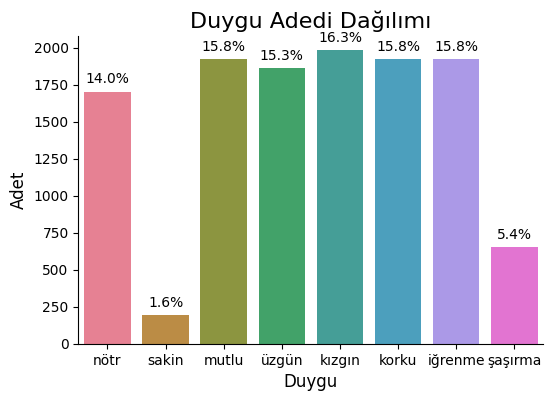

In [20]:
# Dağılım grafiği oluşturma
plt.figure(figsize=(6, 4))
palette = sns.color_palette("husl", len(data_path['Duygu'].unique()))
sns.countplot(data=data_path, x='Duygu', palette=palette)

# Toplam gözlem sayısını bulma
total = len(data_path)

# Yüzde etiketleri ekleme
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    plt.gca().annotate(percentage, 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

# Grafik başlığı ve eksen etiketlerini ayarlama
plt.title('Duygu Adedi Dağılımı', size=16)
plt.ylabel('Adet', size=12)
plt.xlabel('Duygu', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [21]:
# "calm" sınıfını "neutral" sınıfına dönüştürme
data_path['Duygu'] = data_path['Duygu'].replace({'sakin': 'nötr'})

In [22]:
print(data_path['Duygu'].unique())

['nötr' 'mutlu' 'üzgün' 'kızgın' 'korku' 'iğrenme' 'şaşırma']


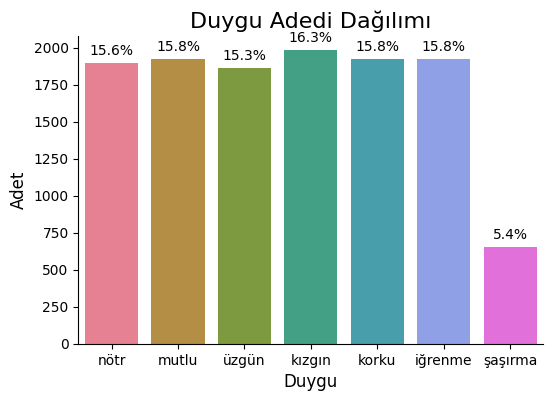

In [23]:
# Dağılım grafiği oluşturma
plt.figure(figsize=(6, 4))
palette = sns.color_palette("husl", len(data_path['Duygu'].unique()))
sns.countplot(data=data_path, x='Duygu', palette=palette)

# Toplam gözlem sayısını bulma
total = len(data_path)

# Yüzde etiketleri ekleme
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    plt.gca().annotate(percentage, 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

# Grafik başlığı ve eksen etiketlerini ayarlama
plt.title('Duygu Adedi Dağılımı', size=16)
plt.ylabel('Adet', size=12)
plt.xlabel('Duygu', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [24]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('{} duygusu içeren ses için dalga grafiği'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [25]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('{} duygusu içeren ses için spektrogram'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

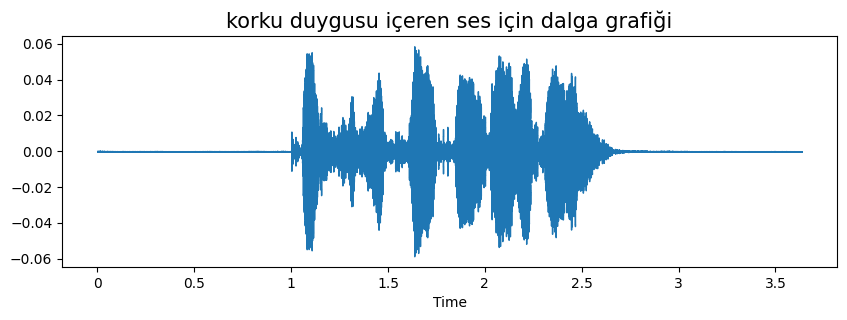

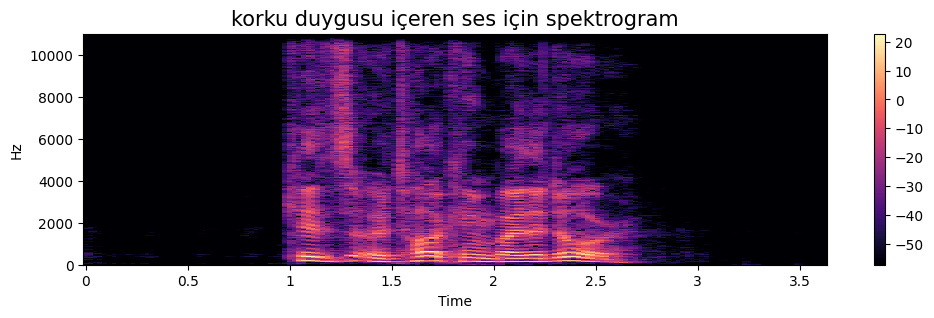

In [26]:
duygu='korku'
path = np.array(data_path.Dosya_Yolu[data_path.Duygu==duygu])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, duygu)
create_spectrogram(data, sampling_rate, duygu)
Audio(path)

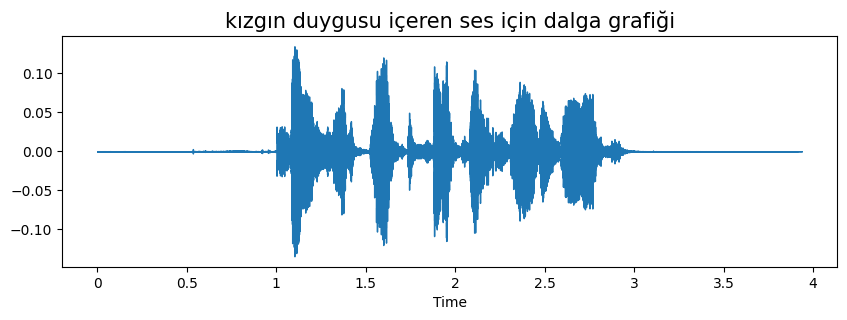

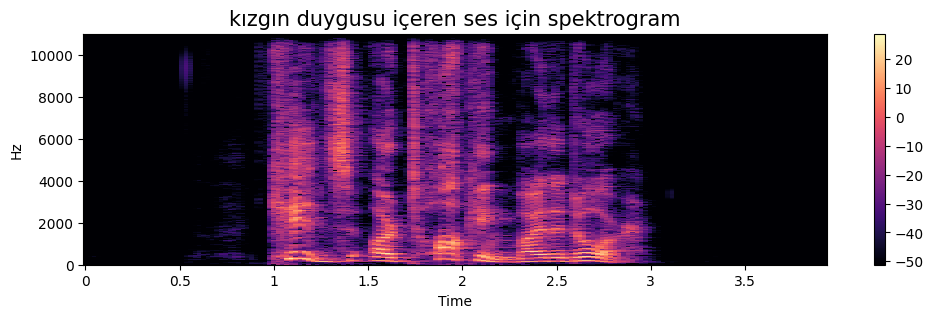

In [27]:
duygu='kızgın'
path = np.array(data_path.Dosya_Yolu[data_path.Duygu==duygu])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, duygu)
create_spectrogram(data, sampling_rate, duygu)
Audio(path)

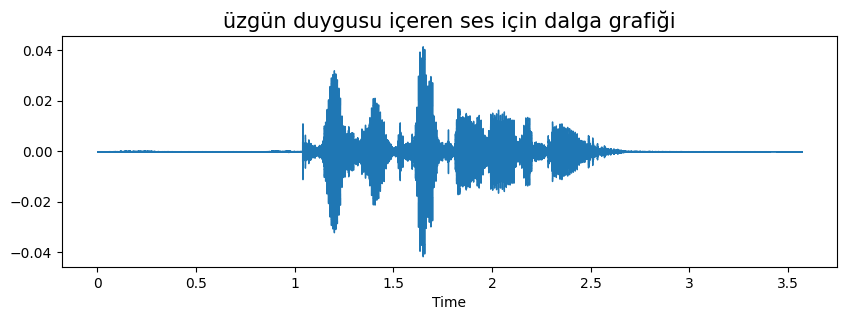

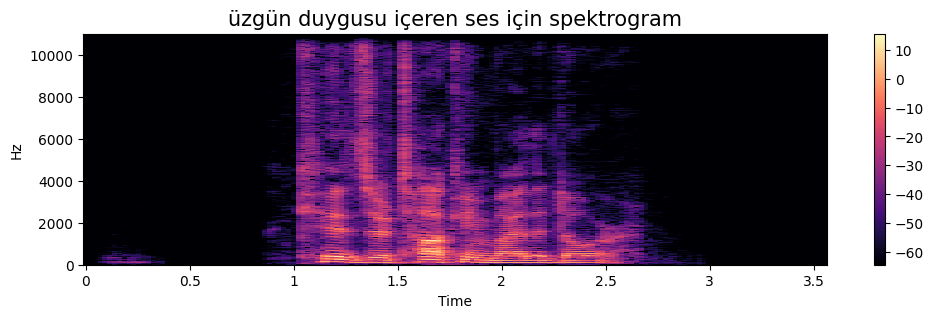

In [28]:
duygu='üzgün'
path = np.array(data_path.Dosya_Yolu[data_path.Duygu==duygu])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, duygu)
create_spectrogram(data, sampling_rate, duygu)
Audio(path)

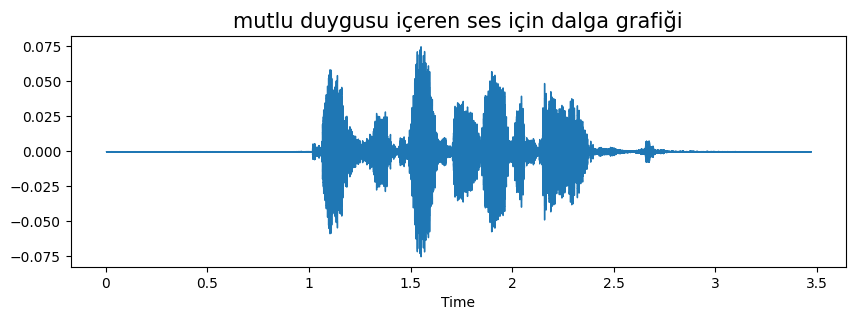

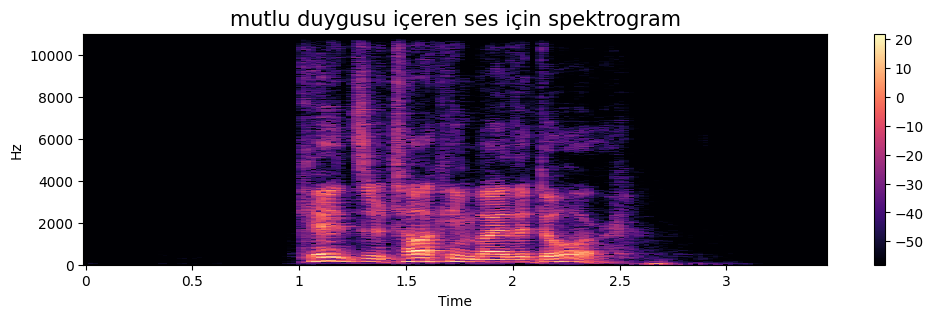

In [29]:
duygu='mutlu'
path = np.array(data_path.Dosya_Yolu[data_path.Duygu==duygu])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, duygu)
create_spectrogram(data, sampling_rate, duygu)
Audio(path)

# 2. VERİ ÇOĞALTMA

In [30]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [31]:
# Herhangi bir örneği alıp teknikleri kontrol edelim
path = np.array(data_path.Dosya_Yolu)[1]
data, sample_rate = librosa.load(path)

1. Örnek Sesimiz

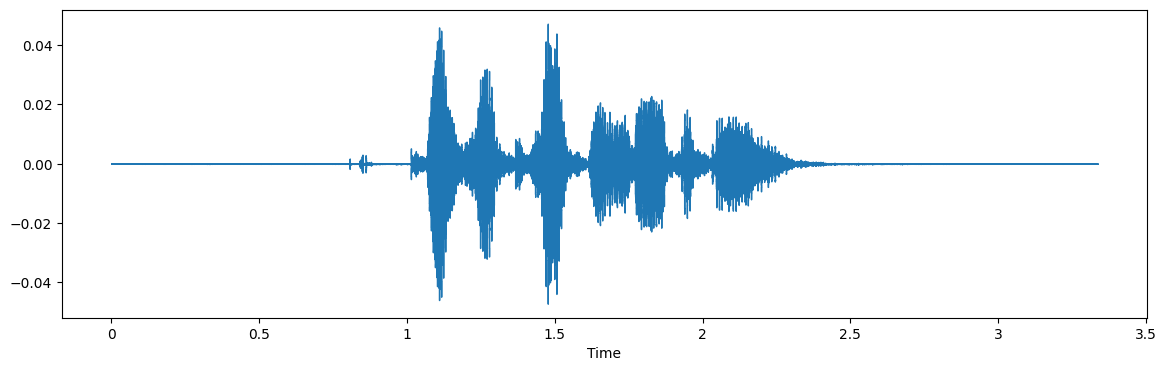

In [32]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

2. Noise Uygulayalım

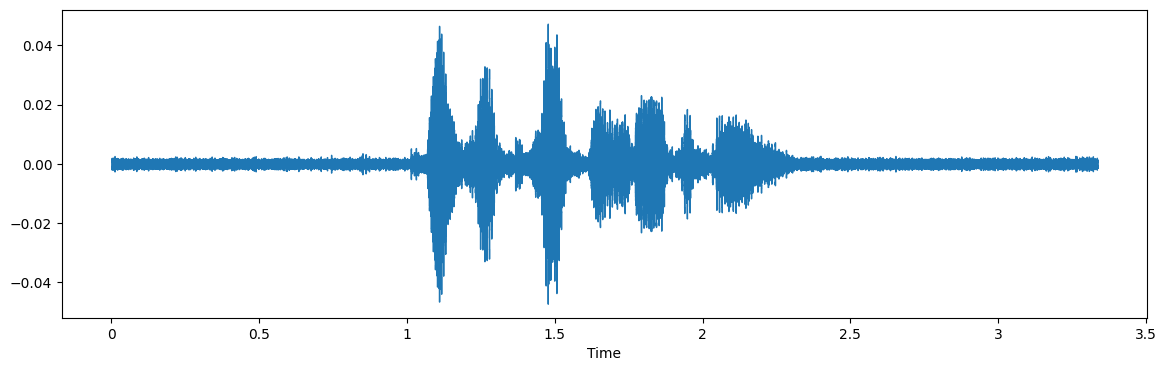

In [33]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

3. Stretching Uygulayalım

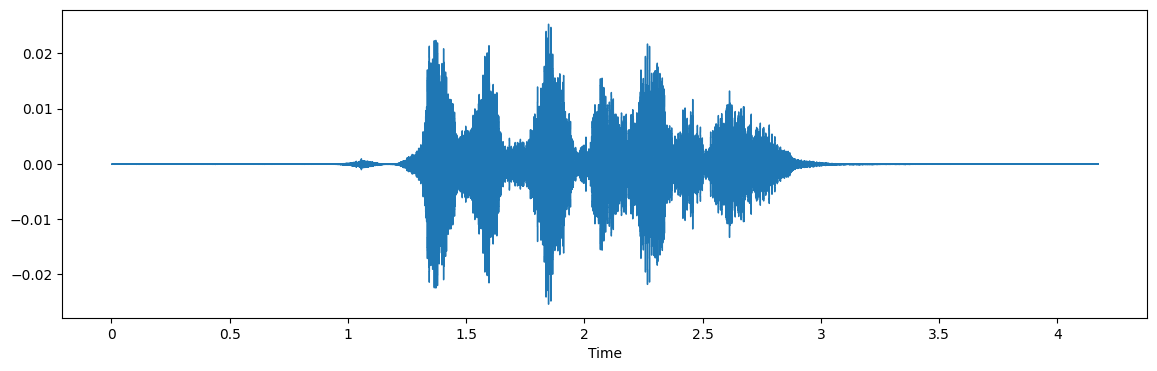

In [34]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

4. Shifting Uygulayalım

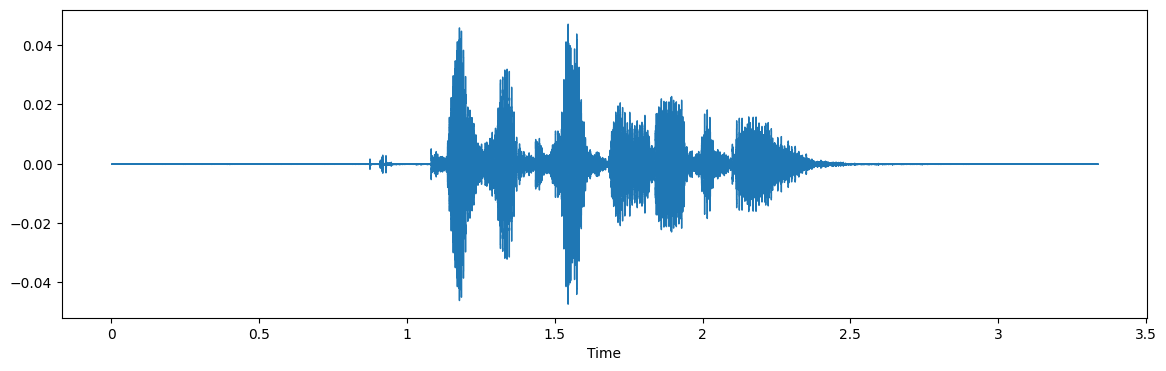

In [35]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

5. Pitch Uygulayalım

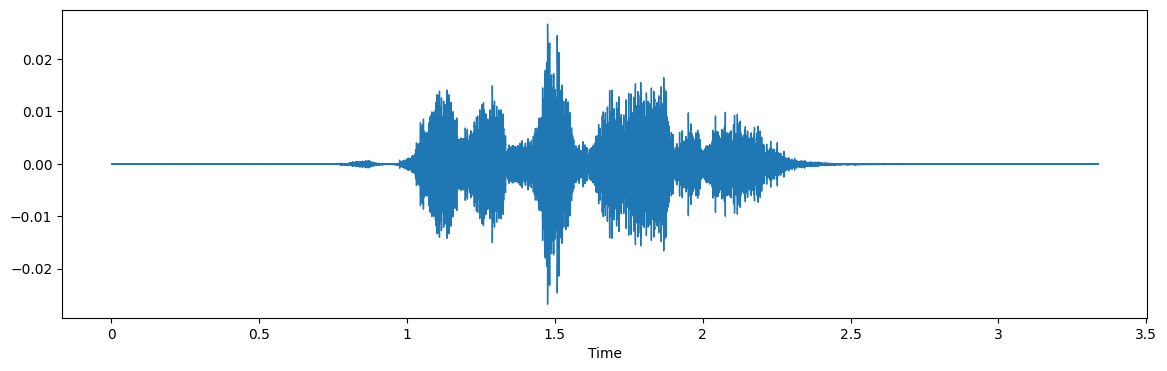

In [36]:
x = pitch(data, sample_rate, 0.7)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Yukarıdaki veri çoğaltma tekniklerinden noise, strecthing  ve pitching kullanmak mantıklı gibi. Shifting datada pek bir değişikliğe sebep olmadı gibi.

# 3. ÖZELLİK ÇIKARMA

Özelliklerin çıkarılması, farklı şeyler arasındaki ilişkilerin analiz edilmesinde ve bulunmasında çok önemli bir bölümdür. Bildiğimiz gibi, ses verilerinin modeller tarafından doğrudan anlaşılması mümkün değildir, bu nedenle bunları özellik çıkarımının kullanıldığı anlaşılabilir bir formata dönüştürmemiz gerekir.

Ses sinyali, üç eksenin zaman, genlik ve frekansı temsil ettiği üç boyutlu bir sinyaldir esasında.

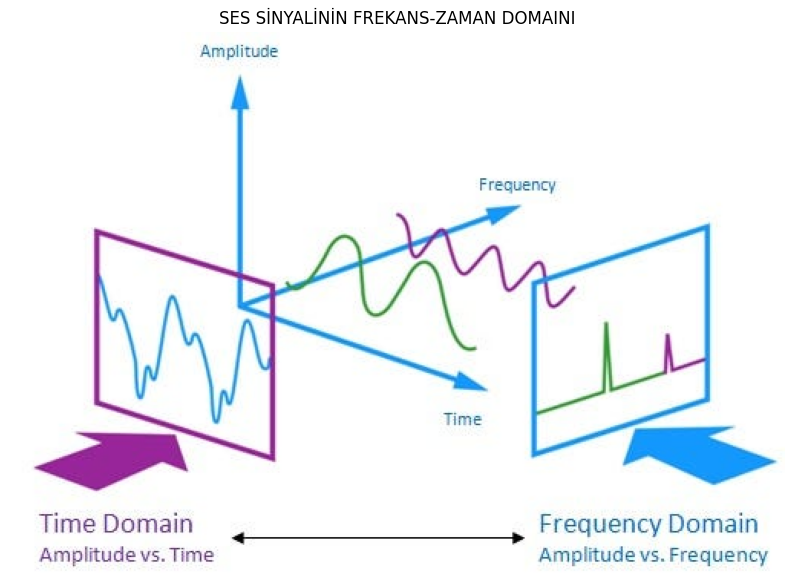

In [37]:
img = Image.open('voice3daxial.jpg')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis('off')
plt.title('SES SİNYALİNİN FREKANS-ZAMAN DOMAINI')
plt.show()

Ses sinyalleri ve ses dosyalarından özellik çıkarma, sinyal işleme ve makine öğrenimi alanlarında önemli bir konudur. 
Ses sinyallerinden çıkarılabilecek öznitelikleri şu şekilde sıralayabiliriz.

Sıfır Geçiş Oranı : bir ses sinyalinin sıfır referans çizgisini geçişlerinin sayısının ölçüsüdür. Bu özellik, sinyalin zaman domeninde ne kadar hızlı değiştiğini gösterir ve özellikle periyodik veya periyodik olmayan sinyallerin analizinde kullanılır. Örneğin, konuşma ve müzik sinyalleri arasındaki farkları tespit etmekte yaygın olarak kullanılır. Yüksek sıfır geçiş oranı, sinyalin daha yüksek frekans bileşenlerine sahip olduğunu gösterir.

Enerji : bir ses sinyalinin içeriğinde taşınan toplam enerji miktarını ifade eder. Bu enerji, sesin yoğunluğu ve süresiyle ilişkilidir ve genellikle sesin gücü veya ses basıncı düzeyi (SPL) olarak ölçülür. Ses enerjisi, genellikle karekök ortalama kare (RMS) yöntemiyle hesaplanır ve bu değer, sinyalin güç spektrumuna dayalı olarak belirlenir.

Enerji Entropisi : Ses sinyalinin enerji dağılımının rastgeleliğini veya düzensizliğini ölçen bir özelliktir. Enerji entropisi, ses sinyalindeki farklı segmentlerin enerji yoğunluklarının varyansını değerlendirir. Yüksek enerji entropisi değerleri, enerji yoğunluğunun düzensiz dağıldığı, düşük enerji entropisi değerleri ise daha düzenli ve homojen bir enerji dağılımını ifade eder.

Spektral Merkez : Bir ses sinyalinin spektrumunun ağırlık merkezi olarak tanımlanır. Daha basit bir ifadeyle, spektral merkez, spektral yoğunluğun "ağırlık merkezini" belirler ve sesin "parlaklığı" hakkında bilgi verir. Yüksek spektral merkez değerleri, genellikle parlak veya tiz seslerle ilişkilidirken, düşük spektral merkez değerleri daha karanlık veya bas seslerle ilişkilidir.

Spektral Yayılma : Ses sinyalinin spektral merkez etrafındaki dağılımının bir ölçüsüdür. Basit bir ifadeyle, spektral yayılma, frekans bileşenlerinin spektral merkez etrafında ne kadar geniş bir alana yayıldığını ifade eder. Yüksek spektral yayılma, frekans bileşenlerinin geniş bir aralığa yayıldığını gösterirken, düşük spektral yayılma daha dar bir frekans aralığını ifade eder.

Spektral Entropi : Bir ses sinyalinin spektral içeriğinin düzensizliğini veya belirsizliğini ölçen bir özelliktir. Bu, ses sinyalinin frekans spektrumunun ne kadar "karmaşık" olduğunu belirlemeye yardımcı olur. Düşük spektral entropi, spektrumun belirli frekanslarda yoğunlaştığını, yüksek spektral entropi ise enerjinin daha geniş bir frekans aralığına yayıldığını gösterir.

Spektral Akı : Bir ses sinyalinin ardışık spektrumları arasındaki değişimin bir ölçüsüdür. Genellikle zaman içindeki spektral değişiklikleri analiz etmek için kullanılır ve ses sinyalinin periyodik bileşenlerinin veya ani değişimlerinin tespiti için oldukça faydalıdır. Yüksek spektral akı değerleri, frekans içeriğinde hızlı değişiklikler olduğunu gösterir.

Spektral Rolloff : Bir ses sinyalinin spektral içeriğinin enerji yoğunluğunun yüzde kaçının belirli bir frekansın altında toplandığını gösterir. Genellikle, spektral rolloff frekansı, toplam enerji yoğunluğunun %85'inin altındaki frekans olarak tanımlanır. Bu metrik, sesin ton kalitesi ve parlaklığı hakkında bilgi verir; yüksek rolloff değerleri daha keskin veya tiz sesler, düşük rolloff değerleri ise daha yumuşak veya bas sesler anlamına gelir.

Kroma Vektörü :  Bir ses sinyalinin armonik içeriğini tanımlayan bir özellik vektörüdür. Müzikal perdelerin her biri için enerji seviyelerini temsil eder. Kroma vektörleri, müzik bilgisi işleme ve akor tanıma gibi müzik analiz uygulamalarında sıkça kullanılır. Her bir kroma, genellikle bir oktavın 12 yarı tonuna karşılık gelen 12 boyutlu bir vektördür ve her boyut belirli bir müzik notasının enerji seviyesini ifade eder.

Kroma Sapması : Bir ses sinyalinin kroma vektöründeki dağılımın değişkenliğini ölçen bir özelliktir. Kısacası, kroma sapması, ses sinyalindeki belirli frekans bileşenlerinin dağılımının ne kadar yaygın veya yoğun olduğunu belirler. Bu metrik, müzik sinyallerinin analizinde ve özellikle farklı armonik yapıların tespit edilmesinde kullanılır. Kroma sapması, belirli bir müzikal tonun ne kadar istikrarlı veya değişken olduğunu anlamaya yardımcı olabilir.

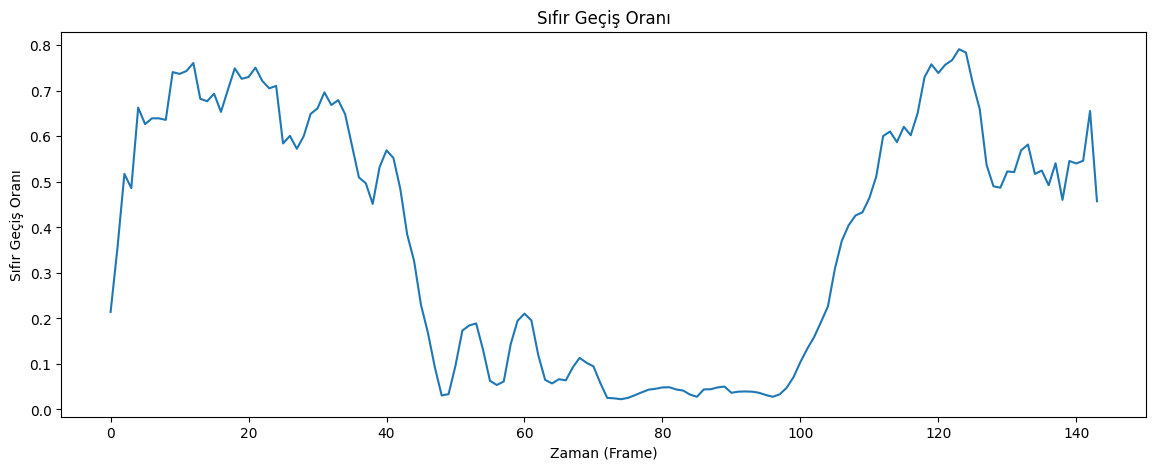

In [38]:
# Sıfır geçiş oranını hesapla
zero_crossings = librosa.feature.zero_crossing_rate(data)

# Sıfır geçiş oranını görselleştir
plt.figure(figsize=(14, 5))
plt.plot(zero_crossings[0])
plt.title('Sıfır Geçiş Oranı')
plt.xlabel('Zaman (Frame)')
plt.ylabel('Sıfır Geçiş Oranı')
plt.show()

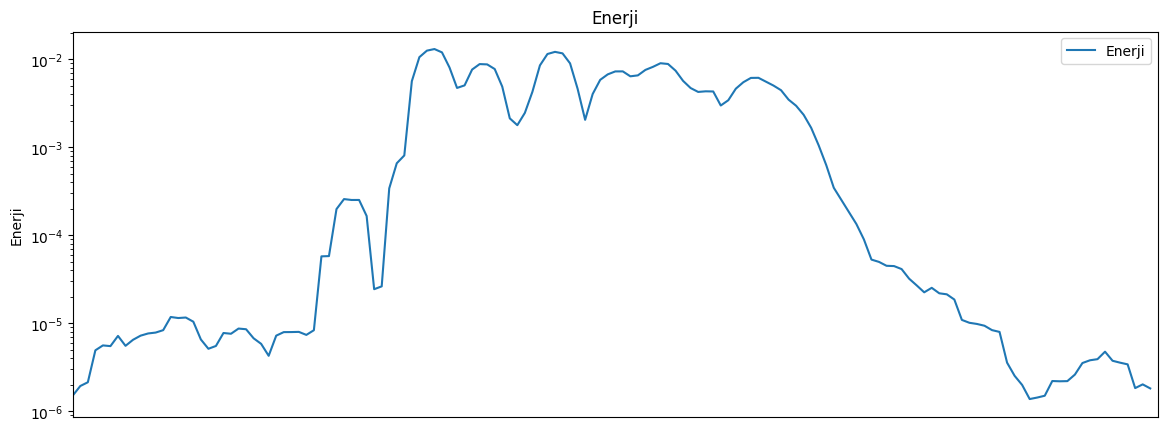

In [39]:
# Kısa zamanlı enerji hesapla
energy = librosa.feature.rms(y=data)

# Enerjiyi görselleştir
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.semilogy(energy.T, label='Enerji')
plt.ylabel('Enerji')
plt.title('Enerji')
plt.xticks([])
plt.xlim([0, energy.shape[-1]])
plt.legend(loc='upper right')
plt.show()

In [40]:
def energy_entropy(y, frame_length=2048, hop_length=512, num_segments=10):
    # Frame bazlı enerji hesapla
    energy = np.array([
        sum(abs(y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    
    # Her bir frame'in enerjisini normalize et
    energy = energy / np.sum(energy)

    # Enerjiyi segmentlere böl ve her segmentin entropisini hesapla
    segment_size = len(energy) // num_segments
    entropy = []
    for i in range(num_segments):
        segment = energy[i*segment_size:(i+1)*segment_size]
        probs = segment / np.sum(segment)
        ent = -np.sum(probs * np.log2(probs + 1e-10))
        entropy.append(ent)
    
    return np.mean(entropy)

In [41]:
# Enerji entropisini hesapla
entropi = energy_entropy(data)
print(f'Enerji Entropisi: {entropi}')

Enerji Entropisi: 3.1272171930199413


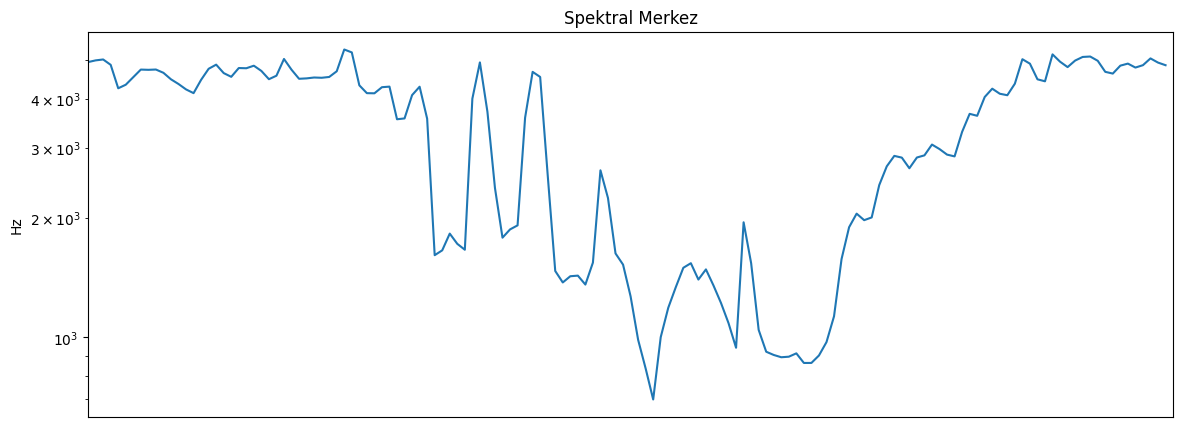

In [42]:
# Spektral merkezi hesaplayın
spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sample_rate)

# Spektral merkezi görselleştirin
plt.figure(figsize=(14, 5))
plt.semilogy(spectral_centroid.T)
plt.ylabel('Hz')
plt.xticks([])
plt.title('Spektral Merkez')
plt.xlim([0, spectral_centroid.shape[-1]])
plt.show()

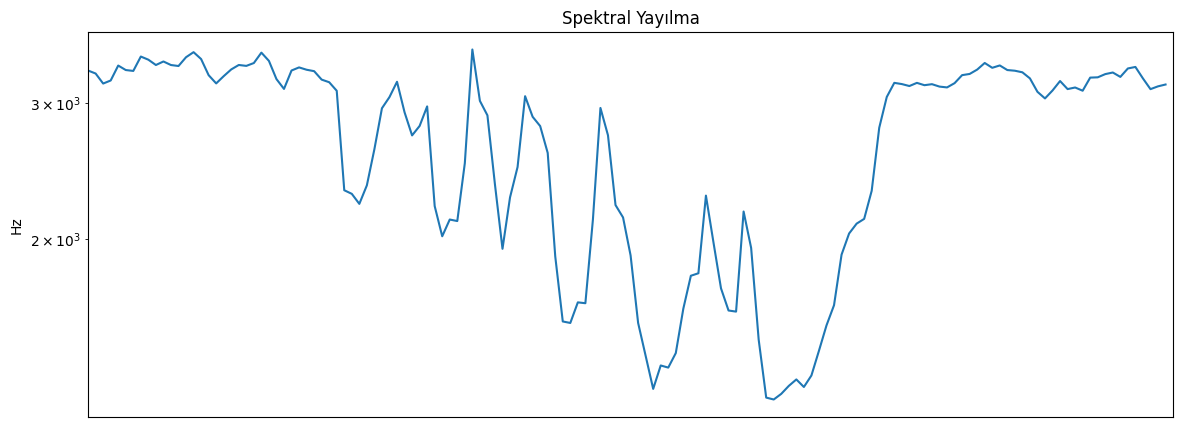

In [43]:
# Spektral yayılmayı hesapla
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, centroid=spectral_centroid)

# Spektral merkezi ve yayılmayı görselleştir
plt.figure(figsize=(14, 5))
plt.semilogy(spectral_bandwidth.T, label='Spektral Yayılma')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, spectral_centroid.shape[-1]])
plt.title('Spektral Yayılma')
plt.show()

In [44]:
def spectral_entropy(y, sr, n_fft=2048, hop_length=512):
    # STFT (Short-Time Fourier Transform) hesapla
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    
    # Güç spektrumu hesapla
    power_spectrum = S**2
    
    # Her bir zaman dilimi için toplam güç hesapla
    ps_norm = power_spectrum / np.sum(power_spectrum, axis=0, keepdims=True)
    
    # Entropiyi hesapla
    spectral_entropy = -np.sum(ps_norm * np.log2(ps_norm + 1e-10), axis=0)
    
    return spectral_entropy

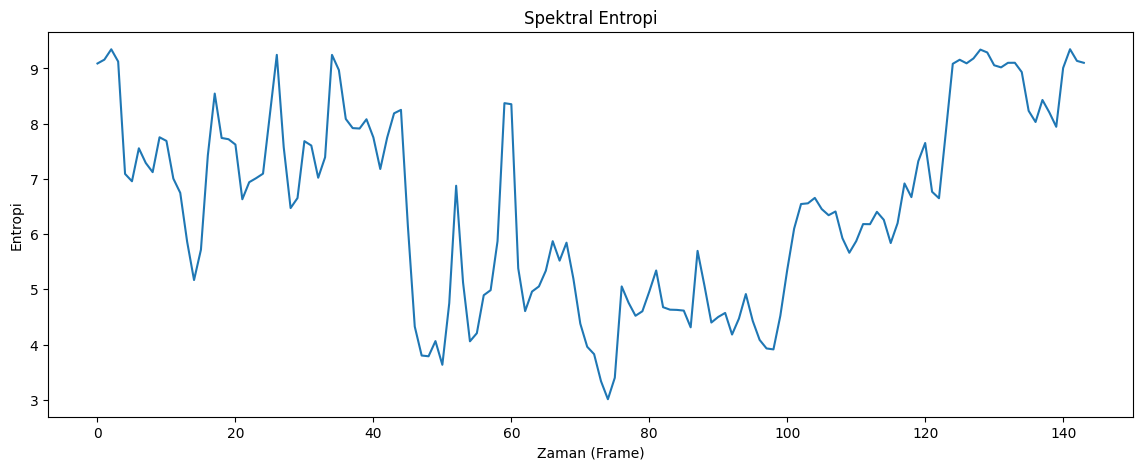

In [45]:
# Spektral entropiyi hesapla
entropy = spectral_entropy(data, sample_rate)

# Entropiyi görselleştir
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.plot(entropy)
plt.title('Spektral Entropi')
plt.ylabel('Entropi')
plt.xlabel('Zaman (Frame)')
plt.show()

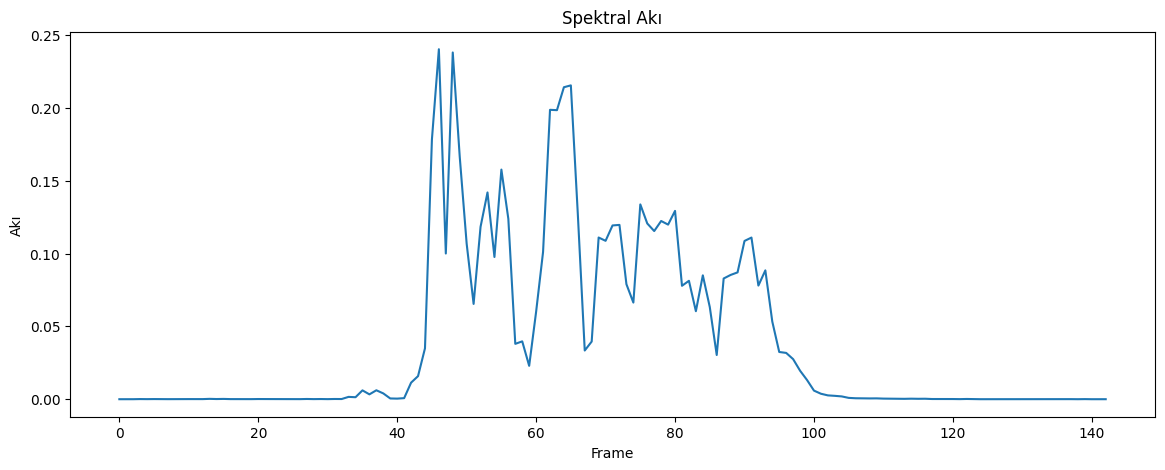

In [48]:
# STFT hesapla
S = np.abs(librosa.stft(data))

# Spektral akıyı hesapla
spectral_flux = np.sqrt(np.mean(np.diff(S, axis=1)**2, axis=0))

# Spektral akıyı görselleştir
plt.figure(figsize=(14, 5))
plt.plot(spectral_flux)
plt.title('Spektral Akı')
plt.xlabel('Frame')
plt.ylabel('Akı')
plt.show()

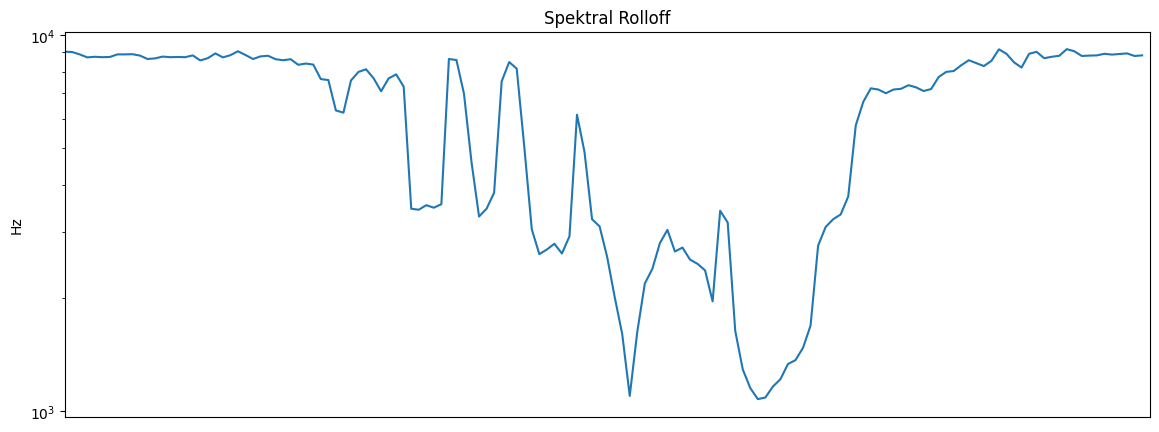

In [49]:
# Spektral rolloff'u hesapla
spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate, roll_percent=0.85)

# Spektral rolloff'u görselleştir
plt.figure(figsize=(14, 5))
plt.semilogy(spectral_rolloff.T)
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, spectral_rolloff.shape[-1]])
plt.title('Spektral Rolloff')
plt.show()

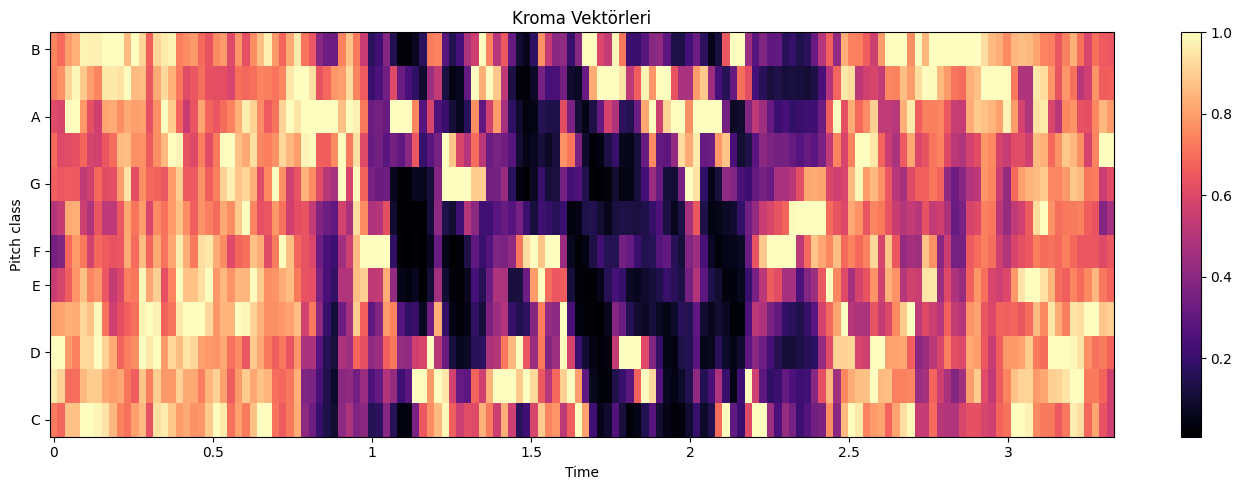

In [50]:
# Kroma özelliklerini hesapla
chromagram = librosa.feature.chroma_stft(y=data, sr=sample_rate)

# Kroma vektörlerini görselleştir
plt.figure(figsize=(14, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', sr=sample_rate)
plt.colorbar()
plt.title('Kroma Vektörleri')
plt.tight_layout()
plt.show()

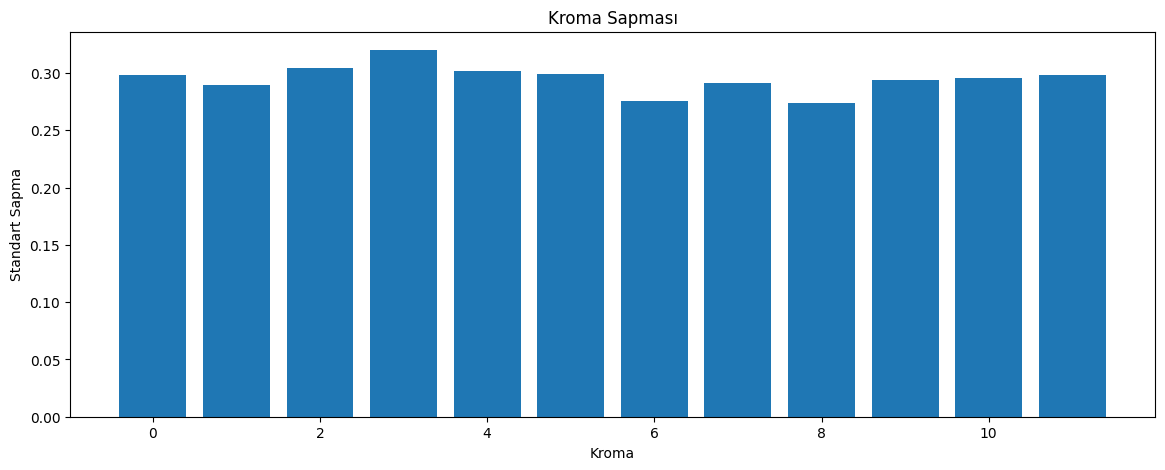

In [51]:
# Kroma vektörlerini hesapla
chromagram = librosa.feature.chroma_stft(y=data, sr=sample_rate)

# Kroma sapmasını hesapla
chroma_std = np.std(chromagram, axis=1)

# Kroma sapmasını görselleştir
plt.figure(figsize=(14, 5))
plt.bar(range(len(chroma_std)), chroma_std)
plt.xlabel('Kroma')
plt.ylabel('Standart Sapma')
plt.title('Kroma Sapması')
plt.show()

In [52]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, hop_length=hop_length)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [53]:
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Dosya_Yolu,data_path.Duygu,range(data_path.Dosya_Yolu.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done') 

4it [00:00, 15.68it/s]

0 audio has been processed


504it [00:27, 19.10it/s]

500 audio has been processed


1004it [00:56, 17.13it/s]

1000 audio has been processed


1503it [01:25, 20.13it/s]

1500 audio has been processed


2004it [01:53, 18.30it/s]

2000 audio has been processed


2504it [02:19, 20.53it/s]

2500 audio has been processed


3003it [02:42, 19.28it/s]

3000 audio has been processed


3505it [03:06, 22.27it/s]

3500 audio has been processed


4002it [03:30, 20.26it/s]

4000 audio has been processed


4504it [03:55, 18.32it/s]

4500 audio has been processed


5003it [04:19, 18.40it/s]

5000 audio has been processed


5505it [04:43, 19.91it/s]

5500 audio has been processed


6006it [05:07, 22.95it/s]

6000 audio has been processed


6503it [05:31, 21.49it/s]

6500 audio has been processed


7004it [05:56, 22.71it/s]

7000 audio has been processed


7503it [06:22, 19.15it/s]

7500 audio has been processed


8004it [06:48, 20.51it/s]

8000 audio has been processed


8504it [07:13, 22.38it/s]

8500 audio has been processed


9006it [07:37, 30.49it/s]

9000 audio has been processed


9504it [07:57, 26.92it/s]

9500 audio has been processed


10005it [08:17, 23.22it/s]

10000 audio has been processed


10503it [08:40, 20.14it/s]

10500 audio has been processed


11003it [09:00, 24.57it/s]

11000 audio has been processed


11504it [09:21, 22.96it/s]

11500 audio has been processed


12004it [09:47, 17.68it/s]

12000 audio has been processed


12162it [09:56, 20.38it/s]

Done


In [54]:
len(X), len(Y), data_path.Dosya_Yolu.shape

(48648, 48648, (12162,))

In [55]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

0         1         2         3         4         5         6  \
0  0.173828  0.264648  0.372559  0.486328  0.625488  0.681152  0.720703   
1  0.242676  0.376953  0.503906  0.510254  0.516602  0.507324  0.505859   
2  0.256348  0.354492  0.471191  0.414062  0.378418  0.373535  0.354492   
3  0.250488  0.378418  0.505371  0.498535  0.489258  0.485352  0.480957   
4  0.247070  0.389648  0.564941  0.642578  0.665527  0.684570  0.676270   

          7         8         9  ...      1611      1612      1613      1614  \
0  0.651855  0.562988  0.559082  ...  0.816714  0.812341  0.807019  0.800742   
1  0.505859  0.503418  0.512695  ... -1.477674 -3.626658 -3.334802  0.489428   
2  0.408691  0.466797  0.522461  ...  0.007222  0.007180  0.007128  0.007062   
3  0.484375  0.491211  0.488770  ...  0.721807 -0.648204  0.135006  5.668650   
4  0.666992  0.648926  0.595703  ...  0.000000  0.000000  0.000000  0.000000   

       1615      1616      1617      1618      1619  Emotions  
0  0.793534  0.785372  0.776301  0.766315  0.755441      nötr  
1  2.499175  1.809815 -3.700802 -5.309332 -2.782225      nötr  
2  0.006994  0.006906  0.006816  0.006713  0.006601      nötr  
3  7.611513  1.221735  2.991531  2.502542  3.536261      nötr  
4  0.000000  0.000000  0.000000  0.000000  0.000000      nötr  

[5 rows x 1621 columns]

# 4. VERİ ÖN İŞLEME

In [56]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
1616         True
1617         True
1618         True
1619         True
Emotions    False
Length: 1621, dtype: bool


In [57]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
1616        False
1617        False
1618        False
1619        False
Emotions    False
Length: 1621, dtype: bool


(48648, 1621)

In [184]:
Emotions.describe().T

count      mean       std        min       25%       50%       75%  \
0     48648.0  0.065029  0.073954   0.000000  0.020020  0.031738  0.073242   
1     48648.0  0.097584  0.108689   0.000000  0.030762  0.049316  0.109863   
2     48648.0  0.130143  0.142217   0.000000  0.042480  0.067871  0.146973   
3     48648.0  0.129458  0.140842   0.000000  0.042969  0.068359  0.145020   
4     48648.0  0.129490  0.139724   0.000000  0.043945  0.069824  0.145020   
...       ...       ...       ...        ...       ...       ...       ...   
1615  48648.0 -0.174632  3.729736 -60.734779  0.000000  0.000000  0.000000   
1616  48648.0  0.321791  3.311142 -41.710526  0.000000  0.000000  0.000000   
1617  48648.0 -0.002349  3.051527 -48.309353  0.000000  0.000000  0.000000   
1618  48648.0 -0.154939  2.802418 -43.894180  0.000000  0.000000  0.000000   
1619  48648.0  0.046424  2.712369 -34.190323  0.000000  0.000000  0.000000   

            max  
0      0.461914  
1      0.686035  
2      0.916504  
3      0.922852  
4      0.920410  
...         ...  
1615  36.832970  
1616  41.923340  
1617  37.897141  
1618  31.046314  
1619  32.699760  

[1620 rows x 8 columns]

In [58]:
X = Emotions.iloc[: ,:-1].values
y = Emotions['Emotions'].values

In [59]:
X.shape

(48648, 1620)

In [60]:
y.shape

(48648,)

In [61]:
y

array(['nötr', 'nötr', 'nötr', ..., 'şaşırma', 'şaşırma', 'şaşırma'],
      dtype=object)

In [62]:
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [63]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [64]:
y.shape

(48648, 7)

In [65]:
X.shape

(48648, 1620)

# 4. DATAYI SPLIT ETME

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2, shuffle=True)

In [67]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38918, 1620), (38918, 7), (9730, 1620), (9730, 7))

# 5. CNN MODELİ HAZIRLIĞI

In [68]:
X_traincnn =np.expand_dims(X_train, axis=2)
X_testcnn= np.expand_dims(X_test, axis=2)
X_traincnn.shape, y_train.shape, X_testcnn.shape, y_test.shape

((38918, 1620, 1), (38918, 7), (9730, 1620, 1), (9730, 7))

In [69]:
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

In [75]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [81]:
model = tf.keras.Sequential([
    Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    
    Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    
    Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    Flatten(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(7,activation='softmax')
])

In [82]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1620, 512)         3072      
                                                                 
 batch_normalization_6 (Bat  (None, 1620, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 810, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 810, 512)          1311232   
                                                                 
 batch_normalization_7 (Bat  (None, 810, 512)          2048      
 chNormalization)                                                
                                                      

In [84]:
history=model.fit(X_traincnn, y_train, epochs=50, validation_data=(X_testcnn, y_test), batch_size=64,
                  callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
609/609 [==============================] - 1617s 3s/step - loss: 1.3970 - accuracy: 0.4674 - val_loss: 1.2652 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 2/50
609/609 [==============================] - 1587s 3s/step - loss: 1.1583 - accuracy: 0.5530 - val_loss: 1.2046 - val_accuracy: 0.5216 - lr: 0.0010
Epoch 3/50
609/609 [==============================] - 1667s 3s/step - loss: 1.0509 - accuracy: 0.5981 - val_loss: 1.0998 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 4/50
609/609 [==============================] - 1683s 3s/step - loss: 0.9572 - accuracy: 0.6333 - val_loss: 1.0463 - val_accuracy: 0.5846 - lr: 0.0010
Epoch 5/50
609/609 [==============================] - 1690s 3s/step - loss: 0.8609 - accuracy: 0.6713 - val_loss: 0.9108 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 6/50
609/609 [==============================] - 1563s 3s/step - loss: 0.7556 - accuracy: 0.7164 - val_loss: 1.0092 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 7/50
609/609 [==============================] - 1557

In [85]:
model.save('my_model.h5')

In [86]:
print("Accuracy of our model on test data : " , model.evaluate(X_testcnn,y_test)[1]*100 , "%")

305/305 [==============================] - 70s 228ms/step - loss: 0.0472 - accuracy: 0.9918
Accuracy of our model on test data :  99.1778016090393 %


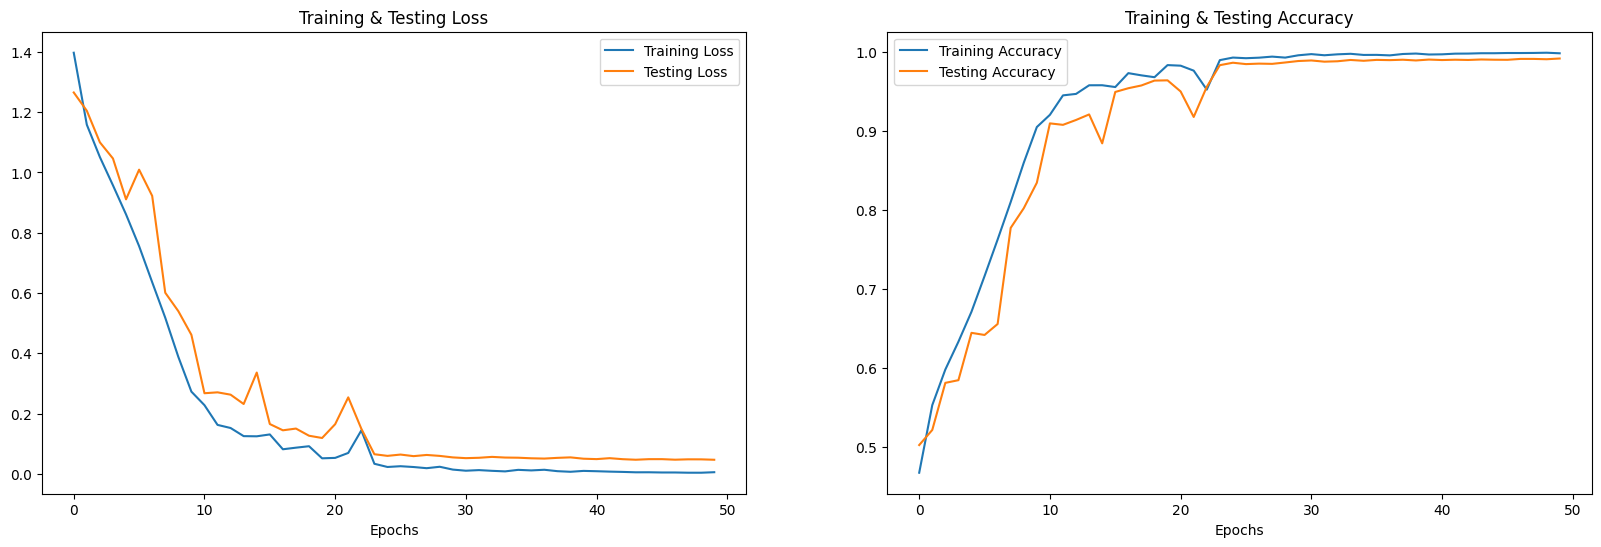

In [87]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [88]:
# predicting on test data.
pred_test0 = model.predict(X_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(50)

305/305 [==============================] - 70s 228ms/step


Predicted Labels Actual Labels
0              nötr          nötr
1           iğrenme       iğrenme
2             korku         korku
3            kızgın        kızgın
4             korku         korku
5            kızgın        kızgın
6            kızgın        kızgın
7             korku         korku
8            kızgın        kızgın
9             korku         korku
10            üzgün         üzgün
11           kızgın        kızgın
12            mutlu         mutlu
13          iğrenme       iğrenme
14             nötr          nötr
15            korku         korku
16           kızgın        kızgın
17          şaşırma       şaşırma
18            korku         korku
19           kızgın        kızgın
20           kızgın        kızgın
21          iğrenme       iğrenme
22            mutlu         mutlu
23            korku         korku
24            korku         korku
25          şaşırma       şaşırma
26          iğrenme       iğrenme
27             nötr          nötr
28            korku         korku
29            üzgün         üzgün
30            üzgün         üzgün
31             nötr          nötr
32            mutlu         mutlu
33           kızgın        kızgın
34            korku         korku
35            mutlu         mutlu
36             nötr          nötr
37            korku         korku
38            üzgün         üzgün
39            korku         korku
40          iğrenme       iğrenme
41             nötr          nötr
42             nötr          nötr
43          iğrenme       iğrenme
44            mutlu         mutlu
45          şaşırma       şaşırma
46            korku         korku
47            üzgün         üzgün
48           kızgın        kızgın
49            korku         korku

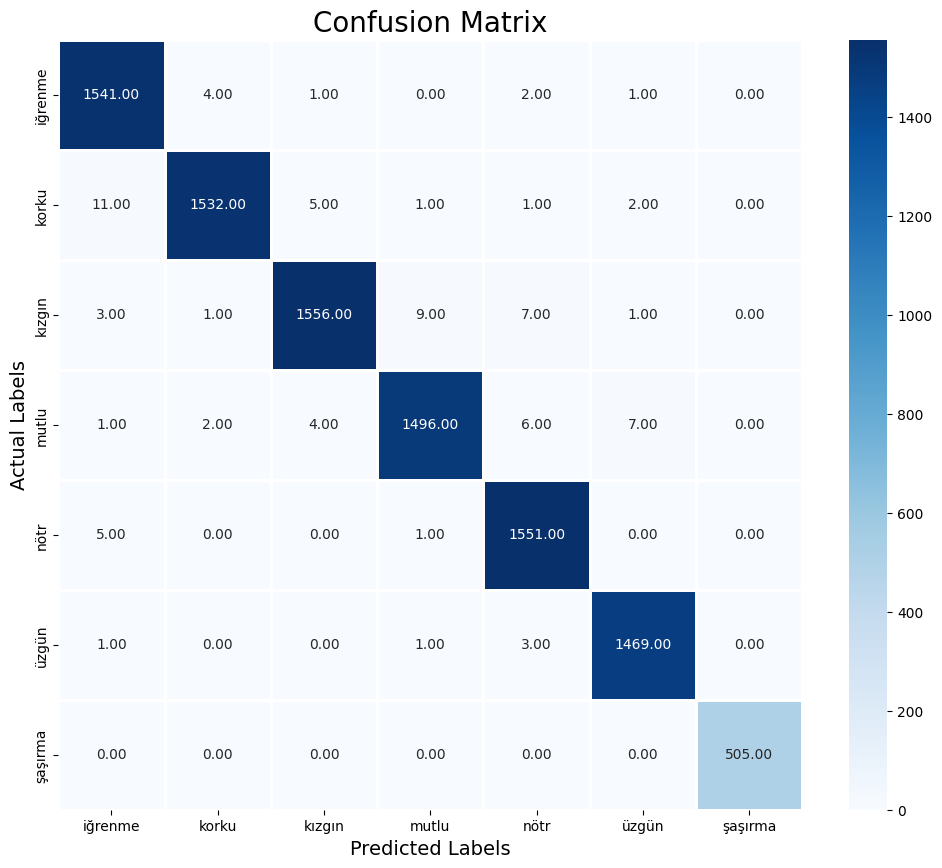

              precision    recall  f1-score   support

     iğrenme       0.99      0.99      0.99      1549
       korku       1.00      0.99      0.99      1552
      kızgın       0.99      0.99      0.99      1577
       mutlu       0.99      0.99      0.99      1516
        nötr       0.99      1.00      0.99      1557
       üzgün       0.99      1.00      0.99      1474
     şaşırma       1.00      1.00      1.00       505

    accuracy                           0.99      9730
   macro avg       0.99      0.99      0.99      9730
weighted avg       0.99      0.99      0.99      9730



In [89]:
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))